# Capacitor Sim
Update the params below and do the appropriate methods 
## TODO:
#### Complete by: 

1. Fix poisson method so the slopes of potential matches with permitvitty (high permitivity = low slope on V-x graph) currently it is the opposite 
2. Need to implement plotting of energy density figures (Navya)
3. Better solver param config, separate sections 
### Distant future
1. Do nanotubes and utilize multigrid or something? 
- For nanotubes - go through literature and design approporiate boundary conditions?
- For multigrid - this is to optimize the solver - go through appropriate PDE book
2. Implement interface physics 
3. Create a responsive dielectric - read Yu and Cardono dielectric function section?
4. IMPORTANT: improve the solver for high dielectrics, the current method (jacobi iteration) does not work well for high $k$ dielectrics
Update the params below and do the appropriate methods.

Read TODO in README.md to see what needs to be done. For reference on how the solver works, check the reference section of the README.md
## Sources
Dielectric loss: https://faculty.kfupm.edu.sa/EE/zhamouz/051/EE620-051/others/2_Dielectric_loss.pdf
Poisson Equation: https://my.ece.utah.edu/~ece6340/LECTURES/Feb1/Nagel%202012%20-%20Solving%20the%20Generalized%20Poisson%20Equation%20using%20FDM.pdf

## Finished tasks - put name 
1. Implement better integration with poisson solver (create solver params) - Nandan 
- Create V_grid, Q, Epsilon, P arrays as instance attributes. Create a solver method (non-static) that uses these class attributes
- By configuring the permittivity and polarization arrays, there can be distinct layers, make it seemless with the solver params
- Create an energy density graph (perhaps using 1/2 epsilon E^2) - read jackson for this 
2. Implement generalized n layer capacitor, combine it with above - Nandan 
3. Added neater/more organized plotting functions - Navya


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors


In [2]:
class Capacitor_Sim:
    def __init__(self):
        # Initialize parameters using dictionaries
        self.dielectric_params = {
            'layer_one_k': 1,
            'layer_two_k': 0.5,
            'layer_three_k': 2,
            'loss_tangent_one': 10e-4,
            'loss_tangent_two': 10e-4,
            'loss_tangent_three': 10e-4
        }
        
        self.resistance_params = {
            'resistance_one': 10e-5,
            'resistance_two': 10e-5,
            'resistance_three': 10e-5
        }
        
        self.dimensions_params = {
            'thickness_one': 1e-6,
            'thickness_two': 0.5e-6,
            'thickness_three': 0.7e-6,
            'number_of_layers': 3,
            'area': 1e-8,
            'length': 1e-5,
            'width': 1e-5,
            'dx': 0.3e-6,
            'dy': 0.3e-6,
            'dz': 0.05e-6
        }
        
        self.miscellaneous_params = {
            'permitivity_free_space': 8.85e-12,
            'layers': 3,    
            'voltage': 10,
            'voltage_frequency': 1,
            'shape': 'rectangle'
        }
        self.solver_params = {
            'voltage_max_steps': 30000,
            'voltage_tolerance': 0.4e-5, 
            'polarization_max_steps': 3000,
            'polarization_tolerance': 0.5e6 * 100 * 50e-13,
            'polarization_step_size': 0.05, 
        }
    
        

        # Initialize instance attributes from dictionaries
        self.initialize_capacitor_params()
        self.initalize_capacitor_structure()

    def initialize_capacitor_params(self):
        # Dielectric parameters
        self.layer_one_k = self.dielectric_params['layer_one_k']
        self.layer_two_k = self.dielectric_params['layer_two_k']
        self.layer_three_k = self.dielectric_params['layer_three_k']
        self.loss_tangent_one = self.dielectric_params['loss_tangent_one']
        self.loss_tangent_two = self.dielectric_params['loss_tangent_two']
        self.loss_tangent_three = self.dielectric_params['loss_tangent_three']

        # Resistance parameters
        self.resistance_one = self.resistance_params['resistance_one']
        self.resistance_two = self.resistance_params['resistance_two']
        self.resistance_three = self.resistance_params['resistance_three']

        # Dimension parameters
        self.thickness_one = self.dimensions_params['thickness_one']
        self.thickness_two = self.dimensions_params['thickness_two']
        self.thickness_three = self.dimensions_params['thickness_three']
        self.layer_number = self.dimensions_params['number_of_layers']
        self.area = self.dimensions_params['area']
        self.length = self.dimensions_params['length']
        self.width = self.dimensions_params['width']
        self.dx = self.dimensions_params['dx']
        self.dy = self.dimensions_params['dy']
        self.dz = self.dimensions_params['dz']

        # Miscellaneous parameters
        self.epsilon0 = self.miscellaneous_params['permitivity_free_space']
        self.layers = self.miscellaneous_params['layers']
        self.voltage = self.miscellaneous_params['voltage']
        self.voltage_frequency = self.miscellaneous_params['voltage_frequency']
        self.shape = self.miscellaneous_params['shape']

        # Solver parameters
        self.jacobi_voltage_max_steps = self.solver_params['voltage_max_steps']
        self.jacobi_voltage_tolerance = self.solver_params['voltage_tolerance']
        self.polarization_max_steps = self.solver_params['polarization_max_steps']
        self.polarization_tolerance = self.solver_params['polarization_tolerance']
        self.polarization_step_size = self.solver_params['polarization_step_size']
        
    def initalize_capacitor_structure(self):
        self.total_thickness = (self.thickness_one + self.thickness_two + self.thickness_three) * self.layer_number
        self.Nx = int(self.dimensions_params['length'] / self.dimensions_params['dx'])
        self.Ny = int(self.dimensions_params['width'] / self.dimensions_params['dy'])
        self.Nz = int(self.total_thickness / self.dimensions_params['dz'])
        self.V_grid = np.zeros((self.Nx+1, self.Ny+1, self.Nz+1))
        self.Epsilon = np.ones((self.Nx, self.Ny, self.Nz)) * self.epsilon0
        self.Q0 = np.zeros((self.Nx+1, self.Ny+1, self.Nz+1))
        self.Px = np.zeros((self.Nx+1, self.Ny+1, self.Nz+1))
        self.Py = np.zeros((self.Nx+1, self.Ny+1, self.Nz+1))
        self.Pz = np.zeros((self.Nx+1, self.Ny+1, self.Nz+1))
        # Set up dielectric layers
        layer_thicknesses = [self.thickness_one, self.thickness_two, self.thickness_three]
        layer_k_values = [self.layer_one_k, self.layer_two_k, self.layer_three_k]

        z_position = 0
        for layer in range(self.layer_number):
            for i, (thickness, k) in enumerate(zip(layer_thicknesses, layer_k_values)):
                z_start = int(z_position / self.dimensions_params['dz'])
                z_end = int((z_position + thickness) / self.dimensions_params['dz'])
                self.Epsilon[:, :, z_start:z_end] *= k
                z_position += thickness
    
        self.V_grid[:, :, 0] = 0  # Ground plane
        self.V_grid[:, :, -1] = self.voltage  # Top electrode   

    @staticmethod
    def equiv_capacitance_series(*args):
        sum_inverse = sum(1 / capacitance for capacitance in args)
        return 1 / sum_inverse

    @staticmethod
    def equiv_capacitance_parallel(*args):
        return sum(args)

    @staticmethod
    def equiv_resistance_series(*args):
        return sum(args)

    @staticmethod
    def Jacobi_poisson_solver(self, V_grid, Epsilon, Q0, Px, Py, Pz):
        epsilon_0 = 8.85e-12
        a = self.dx
        b = self.dy
        c = self.dz
        Epsilon = Epsilon.copy()
        Q0 = Q0.copy()
        V_grid = V_grid.copy()
        Px = Px.copy()
        Py = Py.copy()
        Pz = Pz.copy()
        
        e_ijk = Epsilon[:, :, 1:]
        e_i1jk = np.roll(Epsilon[:, :, 1:], 1, axis=0)
        e_ij1k = np.roll(Epsilon[:, :, 1:], 1, axis=1)
        e_ijk1 = Epsilon[:, :, :-1]
        e_i1j1k = np.roll(Epsilon[:, :, 1:], 1, axis=(0, 1))
        e_i1jk1 = np.roll(Epsilon[:, :, :-1], 1, axis=0)
        e_ij1k1 = np.roll(Epsilon[:, :, :-1], 1, axis=1)
        e_i1j1k1 = np.roll(Epsilon[:, :, :-1], 1, axis=(0, 1))

        a0 = (
        (b * c / (4 * a)) * (e_ijk + e_ij1k + e_ijk1 + e_ij1k1) +
        (b * c / (4 * a)) * (e_i1jk + e_i1j1k + e_i1jk1 + e_i1j1k1) +
        (a * c / (4 * b)) * (e_ijk + e_i1jk + e_ijk1 + e_i1jk1) +
        (a * c / (4 * b)) * (e_ij1k + e_i1j1k + e_ij1k1 + e_i1j1k1) +
        (a * b / (4 * c)) * (e_ijk + e_i1jk + e_ij1k + e_i1j1k) +
        (a * b / (4 * c)) * (e_ijk1 + e_i1jk1 + e_ij1k1 + e_i1j1k1)
        )  
        a1 = (
            (b * c / (4 * a)) * (e_ijk + e_ij1k + e_ijk1 + e_ij1k1)
        )
        a2 = (b * c / (4 * a)) * (e_i1jk + e_i1j1k + e_i1jk1 + e_i1j1k1)
        
        a3 = (a * c / (4 * b)) * (e_ijk + e_i1jk + e_ijk1 + e_i1jk1)
        a4 = (a * c / (4 * b)) * (e_ij1k + e_i1j1k + e_ij1k1 + e_i1j1k1)
        a5 = (a * b / (4 * c)) * (e_ijk + e_i1jk + e_ij1k + e_i1j1k)
        a6 = (a * b / (4 * c)) * (e_ijk1 + e_i1jk1 + e_ij1k1 + e_i1j1k1)
        
        polarization_term = ((a*b)/(2*8.85e-12)) * (Pz[1:,0:-1, 1:-1] - np.roll(Pz[0:-1,0:-1, 1:-1], 1, axis=0))
        
        Q_effective = Q0[0:-1, 0:-1, 1:-1] - polarization_term
                                               
        
        
        residual = -V_grid[0:-1, 0:-1, 1:-1] + (a1 * V_grid[1:,0:-1, 1:-1] + a2*np.roll(V_grid[0:-1,0:-1, 1:-1], 1, axis=0)
                                                      + a3*V_grid[0:-1,1:, 1:-1] + a4 * np.roll(V_grid[0:-1,0:-1, 1:-1], 1, axis=1)
                                                      + a5*V_grid[0:-1,0:-1,:-2] + a6*V_grid[0:-1, 0:-1, 2:] + Q_effective /epsilon_0)/a0
        V_grid[0:-1, 0:-1, 1:-1] += residual

        V_grid[:,:, -1] = self.voltage
        V_grid[:,:, 0] = 0
        V_grid[-1,:, :] = V_grid[0,:, :]
        V_grid[:,-1, :] = V_grid[:,0, :]
        error = np.mean(np.abs(residual[:, 1:-1]))
        return V_grid, error
    
    def solve_voltage_Jacobi(self):
        max_iterations = self.jacobi_voltage_max_steps
        
        for i in range(max_iterations):
            if i % 100 == 0:
                print(f"Iteration number: {i}")
            
            self.V_grid, error = self.Jacobi_poisson_solver(self, self.V_grid, self.Epsilon, self.Q0, self.Px, self.Py, self.Pz)
            if error < self.jacobi_voltage_tolerance:
                print(f"Converged after {i+1} iterations")
                break
        else:
            print("Warning: Maximum iterations reached without convergence")
        

    def get_total_capacitance(self):
        e0 = self.epsilon0
        
        if self.shape == 'rectangle':
            c1 = (self.area * self.layer_one_k * e0) / self.thickness_one
            c2 = (self.area * self.layer_two_k * e0) / self.thickness_two
            c3 = (self.area * self.layer_three_k * e0) / self.thickness_three
            
            layer_c = Capacitor_Sim.equiv_capacitance_series(c1, c2, c3)
            total_c = layer_c * self.layers
            
            return total_c
        else:
            return None  

    def dielectric_loss_unit_volume(self):
        e0 = self.epsilon0
        f = self.voltage_frequency
        
        thickness_layer = (self.thickness_one + 
                           self.thickness_two + 
                           self.thickness_three)
        total_thickness = thickness_layer * self.layers
        
        E = self.voltage / total_thickness
        
        total_loss = (self.loss_tangent_one * 
                      self.layer_one_k +
                      self.loss_tangent_two * 
                      self.layer_two_k +
                      self.loss_tangent_three * 
                      self.layer_three_k)
        
        return 2 * np.pi * f * e0 * E**2 * total_loss
    
    def total_energy_capacitor(self):
        return 0.5 * self.get_total_capacitance() * (self.voltage ** 2)
    
    def get_time_constant(self):
        if self.shape == 'rectangle':
            return self.get_total_resistance() * self.get_total_capacitance() 
        else:
            return None  
    
    def get_current(self, time=0):
        tau = self.get_time_constant()
        
        if tau is not None:
            return (self.voltage / 
                    (self.get_total_resistance())) * np.exp(-time / tau)
        
    def get_power(self, time=0):
        current = self.get_current(time)
        
        if current is not None:
            return current**2 * self.get_total_resistance()
    
    
    

In [3]:
class Plot_Sim:
    # Must initialize with a cap_sim object that has been initialized and solved -- solve_voltage_Jacobi() 
    def __init__(self, simulation):
        self.simulation = simulation
        self.loss = self.simulation.dielectric_loss_unit_volume()
        self.total_energy = self.simulation.total_energy_capacitor()
        
        
        #plotting settings
        self.titleweight = "bold"

        %config InlineBackend.figure_format = 'retina'
        %matplotlib inline

        plt.rcParams.update(
        {
        "font.family": "sans-serif",  # Times New Roman, Calibri, Arial
        "font.weight": "normal",
        "mathtext.fontset": "cm",
        "font.size": 13,
        "lines.linewidth": 2,
        "axes.linewidth": 2,
        "axes.spines.top": True,
        "axes.spines.right": True,
        "axes.titleweight": self.titleweight,
        "axes.titlesize": 18,
        "axes.labelweight": "normal",
        "xtick.major.size": 8,
        "xtick.major.width": 2,
        "ytick.major.size": 8,
        "ytick.major.width": 2,
        "figure.dpi": 80,
        "legend.framealpha": 1,
        "legend.edgecolor": "black",
        "legend.fancybox": False,
        "legend.fontsize": 14,
        }
        )
    
    def z_axis(self):
        
        fig, ax = plt.subplots(figsize=(5,5))
        ax.plot(self.simulation.V_grid[self.simulation.Nx//2,self.simulation.Ny//2,:])
        ax.set_title('Voltage Along Z-axis (Center)')
        ax.set_xlabel('Z')
        ax.set_ylabel('Voltage')
        ax.grid(color='k', linestyle='--', linewidth=1)


        #fig.set_tight_layout()
        
        print(f"Min voltage: {np.min(self.simulation.V_grid)}")
        print(f"Max voltage: {np.max(self.simulation.V_grid)}")
        print(f"Mean voltage: {np.mean(self.simulation.V_grid)}")
    
    def xyz_boxplot(self):
        
        V_grid = cap.V_grid
        
        x, y = np.meshgrid(np.arange(V_grid.shape[0]), np.arange(V_grid.shape[1]))
        
        fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
        
        norm = colors.Normalize(vmin=V_grid.min(), vmax=V_grid.max())
        cmap = plt.get_cmap('viridis')
        
        for z_index in range(V_grid.shape[2]):
            Z = V_grid[:, :, z_index]  # Select the voltage values for the current Z slice
            surf = ax.plot_surface(x, y, Z, cmap=cmap, edgecolor='none', alpha=0.7, norm=norm)
        
        colorbar = plt.colorbar(surf, ax=ax)
        colorbar.set_label('Voltage (V)')
        
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Voltage (V)')
        plt.title('3D Surface Plot of Voltage Grid')
        
        plt.show()

    def x_Vcross_section(self, slice):

        
        V_grid = self.simulation.V_grid
        
        x_index = slice  

        cross_section = V_grid[x_index, :, :]

        plt.contourf(cross_section, cmap='viridis')  # Wonder if we should switch the Z vs Y orientation

        plt.colorbar(label='Voltage (V)')

        plt.xlabel('Z axis') 
        plt.ylabel('Y axis')
        plt.title(f'2D Contour Plot of Voltage Grid at X={x_index}')

        plt.show()
    
    def y_Vcross_section(self, slice):

        
        V_grid = self.simulation.V_grid
        
        y_index = slice  

        cross_section = V_grid[:, y_index, :]

        plt.contourf(cross_section, cmap='viridis')

        plt.colorbar(label='Voltage (V)')

        plt.xlabel('Z axis')
        plt.ylabel('X axis')
        plt.title(f'2D Contour Plot of Voltage Grid at Y={y_index}')

        plt.show()

    """must add electric field calcs before finishing energy density"""
    #def energy_density():
        
        
    
        

In [4]:
# Should initialize(&solve) capacitor_sim object before implementing plot class
cap = Capacitor_Sim()

# Store the initial state of V_grid for comparison
initial_V_grid = cap.V_grid.copy()
print(initial_V_grid.shape)
cap.solve_voltage_Jacobi()

(34, 34, 133)
Iteration number: 0
Iteration number: 100
Iteration number: 200
Iteration number: 300
Iteration number: 400
Iteration number: 500
Iteration number: 600
Iteration number: 700
Iteration number: 800
Iteration number: 900
Iteration number: 1000
Iteration number: 1100
Iteration number: 1200
Iteration number: 1300
Iteration number: 1400
Iteration number: 1500
Iteration number: 1600
Iteration number: 1700
Iteration number: 1800
Iteration number: 1900
Iteration number: 2000
Iteration number: 2100
Iteration number: 2200
Iteration number: 2300
Iteration number: 2400
Iteration number: 2500
Iteration number: 2600
Iteration number: 2700
Iteration number: 2800
Iteration number: 2900
Iteration number: 3000
Iteration number: 3100
Iteration number: 3200
Iteration number: 3300
Iteration number: 3400
Iteration number: 3500
Iteration number: 3600
Iteration number: 3700
Iteration number: 3800
Iteration number: 3900
Iteration number: 4000
Iteration number: 4100
Iteration number: 4200
Iteration

Min voltage: 0.0
Max voltage: 10.0
Mean voltage: 4.721574445374874


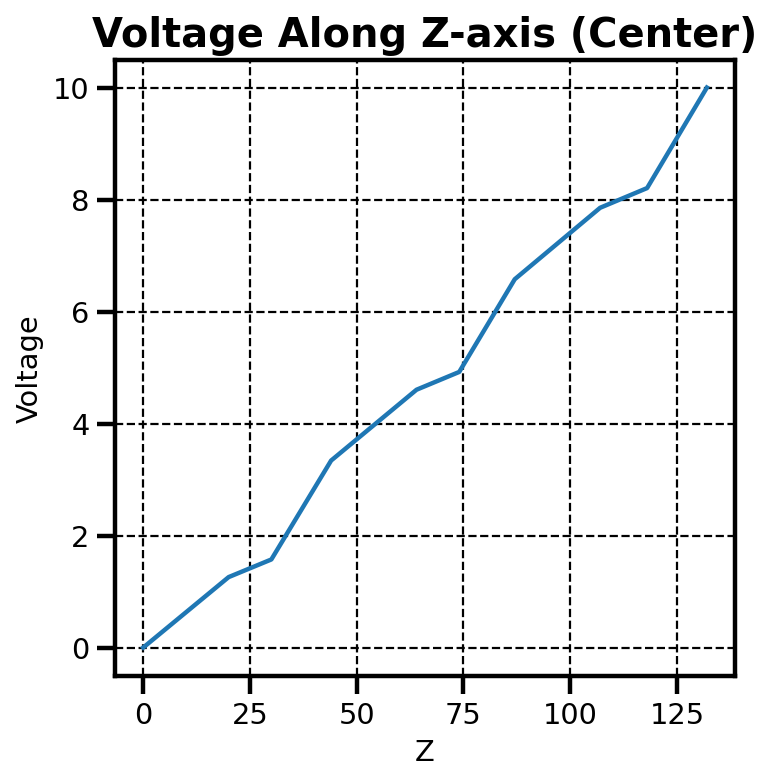

In [5]:
plot = Plot_Sim(cap)
plot.z_axis()

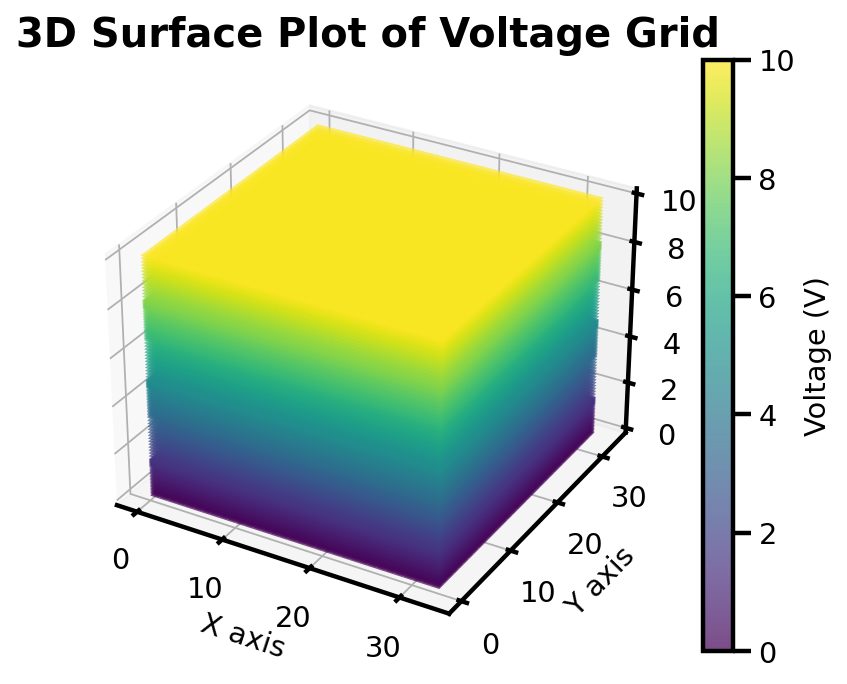

In [6]:
plot.xyz_boxplot()


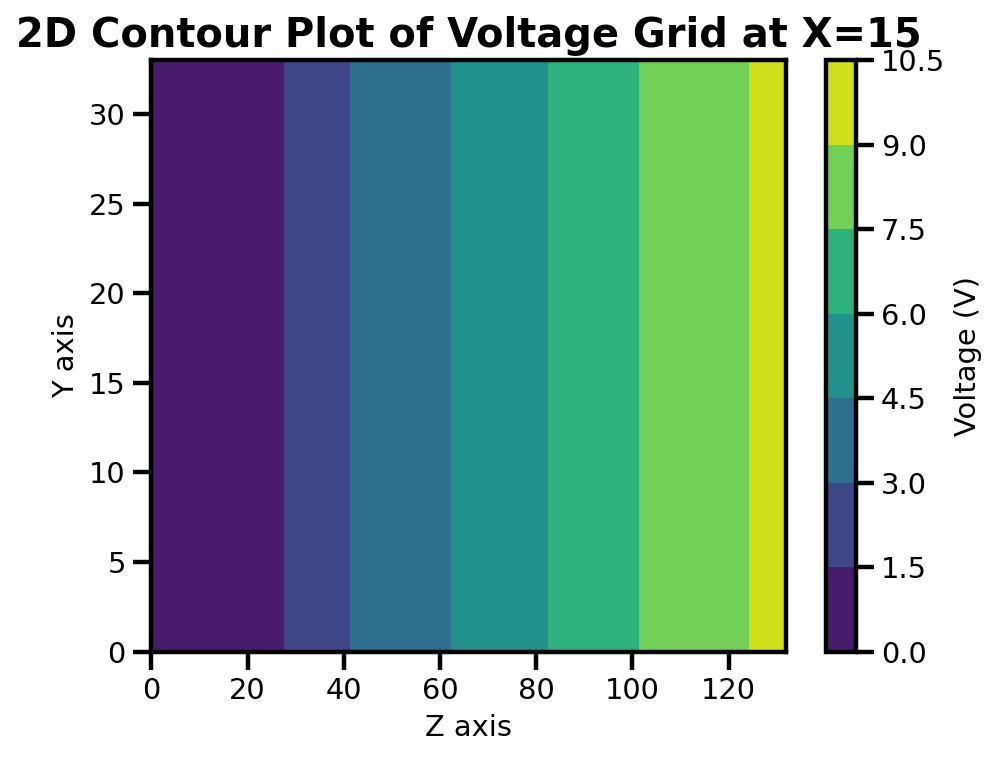

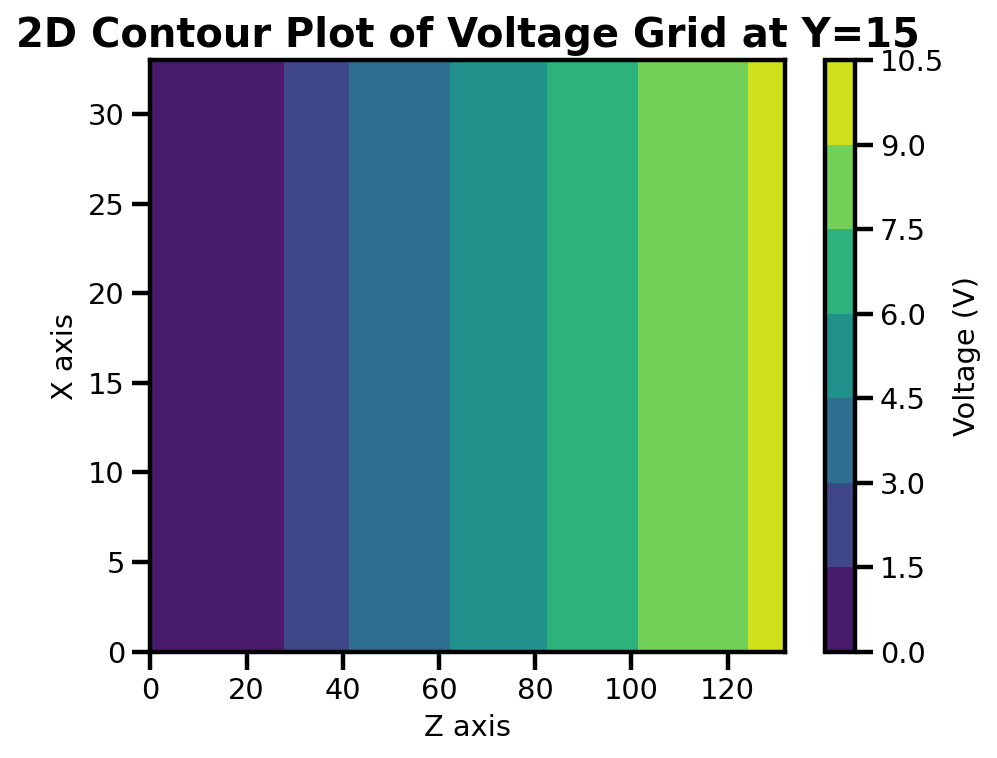

In [7]:
plot.x_Vcross_section(15)
plot.y_Vcross_section(15)


In [8]:
print(plot.loss)
print(plot.total_energy)

0.44678986430185424
5.648936170212767e-12
